In [43]:
LOCAL=False
import os
import importlib
if LOCAL:
    path = '/Users/berk/Documents/research/nna/src/scripts/'
else:
    path = '/home/enis/projects/nna/src/scripts/'
os.chdir(path)

import teacher

# import itertools
import pandas as pd

import glob

# import numpy as np

from pathlib import Path
import csv
import random
import datetime

In [44]:
importlib.reload(teacher)

version_tag='weather_V2'
config = teacher.setup(versiontag=version_tag)

weather_data_folder='/scratch/enis/data/nna/weather_data/2017_2020'
# weather_data_folder='/Users/berk/Downloads/NNA_files/weather_data/2017_2020'
root_path = '/scratch/enis/data/nna/labeling/samples'
config['split_out_path'] = f'{root_path}/{version_tag}/audio_'

## data-1: as many sampes as possible
config['new_dataset_path'] = f'{root_path}/{version_tag}/{version_tag}.csv'
config['dataset_version'] = 'W1'
# config['versiontag'] = 'yfitloiq-V1'
config['excell_label_headers']=['day_length','air_temp','snow_depth',
        'cloud_fraction','relative_humidity','runoff','rain_precip',
         'snow_precip','wind_direction','wind_speed']

# config['excell_label_headers']=['day_length','air_temp','snow_depth',
#         'cloud_fraction','relative_humidity','runoff','rain_precip',
#          'snow_precip','wind_direction','wind_speed',
#         'snow_blowing_ground','snow_blowing_air',]


config['upper_taxo_links']={}

FILE_PER_LOCATION=200
# print('total sample count to be produced:',file_per_location*len(short_ones.keys()))

# 40 Prudhoe or ANWR monitoring sites AND the Ivvavik sites
short_input_csv_headers = ['day_length','air_temp','snow_depth',
        'cloud_fraction','relative_humidity','runoff','rain_precip',
         'snow_precip','wind_direction','wind_speed']
# (year,month,day,hour,day_length,air_temp,snow_depth,
#                 cloud_fraction,relative_humidity,runoff,rain_precip,
#                     snow_precip,wind_direction,wind_speed)=row
# for Dalton and Dempster
long_input_csv_headers = ['day_length','air_temp','snow_depth',
        'cloud_fraction','relative_humidity','runoff','rain_precip',
         'snow_precip','total_precip','wind_direction','wind_speed',
        'snow_blowing_ground','snow_blowing_air']


# (year,month,day,hour,day_length,air_temp,snow_depth,
# cloud_fraction,relative_humidity,runoff,rain_precip,
# snow_precip,total_precip,wind_direction,wind_speed,
# snow_blowing_ground,snow_blowing_air)=row

short_locations=('prudhoe','ivvavik','anwr')
long_locations=('dalton','dempster')
    


In [50]:
if LOCAL:
    file_database = '/Users/berk/Documents/scratch/enis/data/nna/database/allFields_dataV10.pkl'
else:
    file_database = '/scratch/enis/data/nna/database/allFields_dataV10.pkl'
file_properties_df = pd.read_pickle(file_database)

In [51]:

def csv_path_per_regloc(data_folder):
    
    station_csv={}
    for region_path in glob.glob(f'{data_folder}/*'):
        locations=glob.glob(region_path+'/sm_products_by_station/*')
        region = Path(region_path).name.lower()
        for location_path in locations:
            location=Path(location_path).stem.split('_')[-1]
            if region!=location[:-2].lower():
                print(region,location)
            location=location[-2:]
            # print(location_path)
            if region=='ivvavik':
                location='SINP'+location
            station_csv[(region,location)]=location_path
            # print(region,location)
        # print(len(locations))
    return station_csv

def year_per_regloc(station_csv,file_properties_df):

    station_years={}
    for region,location in station_csv.keys():
        region_filtered=file_properties_df[file_properties_df['region']==region]
        loc_reg_filtered = region_filtered[region_filtered['locationId']==location]
        
        # print(region,location)
        unique_years = (loc_reg_filtered.year.unique())
        unique_years = [int(year) for year in unique_years if int(year)>2018]
        # print(unique_years)
        station_years[(region,location)] = unique_years
    return station_years


In [52]:
station_csv = csv_path_per_regloc(weather_data_folder)
station_years = year_per_regloc(station_csv,file_properties_df)


In [61]:
timestamp_offsets = [
    datetime.timedelta(hours=3 * offset / ( + 1))
    for offset in range(1, 5 + 1)
]

In [49]:
# region='dalton'
# location='10'
# region_filtered=file_properties_df[file_properties_df['region']==region]
# loc_reg_filtered = region_filtered[region_filtered['locationId']==location]
# loc_reg_filtered # 2019-07-23_10:30:00

In [53]:
TIMESTAMP_FORMAT = '%Y-%m-%d_%H:%M:%S'

def load_rows(csv_fname,region,short_locations,long_locations):
    with open(csv_fname, newline='') as csvfile:
        # reader = csv.DictReader(csvfile,fieldnames=fieldnames)
        csv_reader = list(csv.reader(csvfile))

        short = True if len(csv_reader[0])==14 else False
        if region in short_locations and not short:
            raise Exception('short location has long csv {}'.format(region))
        if region in long_locations and short:
            raise Exception('long location has short csv {}'.format(region))

        return csv_reader,short

def get_random_rows(reader,file_per_location,station_years):
        # filter rows for available years
        rows_4_available_years = [row for row in reader if int(row[0]) in station_years]
        rows_picked = random.choices(rows_4_available_years,k=file_per_location)
        return rows_picked

def parse_rows(rows_picked,location,region,short,short_headers,long_headers):

    input_csv_headers = short_headers if short else long_headers

    pd_rows=[]
    for row in rows_picked:
        year, month, day, hour = [int(row[x]) for x in range(4)]

        pd_row={}
        pd_row['location']=location
        pd_row['region']=region.lower()
        timestamp = datetime.datetime(year, month, day, hour=hour)
        # timestamps represent timeperiod starting from 3 hours earlier
        # we place them in the middle for finding best representation in audio
        timestamp = timestamp - datetime.timedelta(hours=1.5)
        pd_row['TIMESTAMP']= timestamp.strftime(TIMESTAMP_FORMAT)
        row[4:] = [float(x) for x in row[4:]]
        for label,data in zip(input_csv_headers,row[4:]):
            pd_row[label]=data
        pd_rows.append(pd_row)
    return pd_rows




In [54]:
# # 2019-06-10_07:30:00

# filtered=file_properties_df[file_properties_df['region']=='dalton']
# filtered = filtered[filtered['locationId']=='10']
# filtered=filtered[filtered['timestamp']> datetime.datetime(2019,6,17,0,30,0)]
# filtered=filtered[filtered['timestamp']< datetime.datetime(2019,6,18,0,0,0)]
# filtered

In [55]:
# load_rows(fname,region,short_locations,long_locations)

In [56]:
for (region,location),fname in station_csv.items():
    csv_reader,short = load_rows(fname,region,short_locations,long_locations)
    pd_rows = parse_rows(csv_reader,location,region,short,short_input_csv_headers,long_input_csv_headers)
    selected_data=pd.DataFrame.from_dict(pd_rows)
    break

In [57]:
selected_data

,location,region,TIMESTAMP,day_length,air_temp,snow_depth,cloud_fraction,relative_humidity,runoff,rain_precip,snow_precip,wind_direction,wind_speed
0,SINP03,ivvavik,2017-09-01_01:30:00,14.943919,0.145447,0.013278,0.831613,97.636795,0.000537,0.000537,0.001977,35.069778,4.541947
1,SINP03,ivvavik,2017-09-01_04:30:00,14.943919,0.730835,0.011980,0.831613,95.426025,0.000000,0.000345,0.000541,27.231216,4.000821
2,SINP03,ivvavik,2017-09-01_07:30:00,14.943919,1.566803,0.001721,0.831613,90.637001,0.002508,0.000304,0.000171,20.395065,3.388547
3,SINP03,ivvavik,2017-09-01_10:30:00,14.943919,1.770355,0.000457,0.831613,90.459709,0.001000,0.000170,0.000073,12.971787,2.837646
4,SINP03,ivvavik,2017-09-01_13:30:00,14.943919,1.428864,0.000360,0.831613,92.620537,0.000158,0.000085,0.000057,13.023071,2.202360
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8763,SINP03,ivvavik,2020-08-31_10:30:00,14.943919,4.856476,0.000000,0.831613,91.847214,0.000353,0.000353,0.000000,78.389084,5.976909
8764,SINP03,ivvavik,2020-08-31_13:30:00,14.943919,4.748260,0.000000,0.831613,96.463943,0.000394,0.000394,0.000000,79.693184,5.946101
8765,SINP03,ivvavik,2020-08-31_16:30:00,14.943919,4.888245,0.000000,0.831613,97.798126,0.000369,0.000369,0.000000,87.457062,6.368849
8766,SINP03,ivvavik,2020-08-31_19:30:00,14.943919,5.276306,0.000000,0.831613,97.912010,0.000404,0.000404,0.000000,84.104881,6.062391


In [13]:
#concat data frames


In [14]:
### merge all data to see distributions
dataframes=[]
for (region,location),fname in station_csv.items():
    print(region,location)
    csv_reader,short = load_rows(fname,region,short_locations,long_locations)
    rows_picked = get_random_rows(csv_reader,FILE_PER_LOCATION,station_years[(region,location)])

    pd_rows = parse_rows(rows_picked,location,region,short,short_input_csv_headers,long_input_csv_headers)


    selected_data=pd.DataFrame.from_dict(pd_rows)
    dataframes.append(selected_data)

# unmatching columns will be filled with NaN
# ignore_index=True will create new index
all_data=pd.concat(dataframes,ignore_index=True)

ivvavik SINP03
ivvavik SINP07
ivvavik SINP04
ivvavik SINP08
ivvavik SINP06
ivvavik SINP02
ivvavik SINP10
ivvavik SINP09
ivvavik SINP01
ivvavik SINP05
dempster 12
dempster 15
dempster 22
dempster 19
dempster 21
dempster 24
dempster 16
dempster 11
dempster 25
dempster 20
dempster 14
dempster 13
dempster 23
dempster 17
anwr 43
anwr 47
anwr 50
anwr 34
anwr 38
anwr 37
anwr 33
anwr 44
anwr 40
anwr 48
anwr 39
anwr 35
anwr 31
anwr 46
anwr 42
anwr 49
anwr 41
anwr 45
anwr 32
anwr 36
prudhoe 13
prudhoe 17
prudhoe 28
prudhoe 24
prudhoe 20
prudhoe 23
prudhoe 27
prudhoe 18
prudhoe 14
prudhoe 21
prudhoe 25
prudhoe 29
prudhoe 16
prudhoe 12
prudhoe 11
prudhoe 15
prudhoe 19
prudhoe 30
prudhoe 26
prudhoe 22
dalton 09
dalton 06
dalton 01
dalton 07
dalton 08
dalton 03
dalton 04
dalton 02
dalton 05
dalton 10


In [15]:
all_data

,location,region,TIMESTAMP,day_length,air_temp,snow_depth,cloud_fraction,relative_humidity,runoff,rain_precip,snow_precip,wind_direction,wind_speed,total_precip,snow_blowing_ground,snow_blowing_air
0,SINP03,ivvavik,2017-09-01_01:30:00,14.943919,0.145447,0.013278,0.831613,97.636795,0.000537,0.000537,0.001977,35.069778,4.541947,NaN,NaN,NaN
1,SINP03,ivvavik,2017-09-01_04:30:00,14.943919,0.730835,0.011980,0.831613,95.426025,0.000000,0.000345,0.000541,27.231216,4.000821,NaN,NaN,NaN
2,SINP03,ivvavik,2017-09-01_07:30:00,14.943919,1.566803,0.001721,0.831613,90.637001,0.002508,0.000304,0.000171,20.395065,3.388547,NaN,NaN,NaN
3,SINP03,ivvavik,2017-09-01_10:30:00,14.943919,1.770355,0.000457,0.831613,90.459709,0.001000,0.000170,0.000073,12.971787,2.837646,NaN,NaN,NaN
4,SINP03,ivvavik,2017-09-01_13:30:00,14.943919,1.428864,0.000360,0.831613,92.620537,0.000158,0.000085,0.000057,13.023071,2.202360,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648827,10,dalton,2020-08-31_10:30:00,14.886881,7.361908,0.000000,0.831613,77.358917,0.000044,0.000044,0.000000,39.170822,3.563952,0.000044,0.0,0.0
648828,10,dalton,2020-08-31_13:30:00,14.886881,6.193634,0.000000,0.831613,86.874306,0.000009,0.000009,0.000000,40.309815,3.317840,0.000009,0.0,0.0
648829,10,dalton,2020-08-31_16:30:00,14.886881,3.861450,0.000000,0.831613,91.647201,0.000042,0.000042,0.000000,60.883232,2.315538,0.000042,0.0,0.0
648830,10,dalton,2020-08-31_19:30:00,14.886881,3.343414,0.000000,0.831613,90.887955,0.000012,0.000012,0.000000,78.792786,1.770742,0.000012,0.0,0.0


In [19]:
all_data.columns

Index(['location', 'region', 'TIMESTAMP', 'day_length', 'air_temp',
       'snow_depth', 'cloud_fraction', 'relative_humidity', 'runoff',
       'rain_precip', 'snow_precip', 'wind_direction', 'wind_speed',
       'total_precip', 'snow_blowing_ground', 'snow_blowing_air'],
      dtype='object')

In [23]:
all_data['rain_precip_m'] = all_data['rain_precip']
all_data['rain_precip_mm'] = all_data['rain_precip_m'] * 1000

In [58]:
all_data[['rain_precip_mm']].describe()

,rain_precip_mm
count,648832.000000
mean,0.097085
std,0.382036
min,0.000000
25%,0.000000
50%,0.000000
75%,0.017921
max,15.654719


In [17]:
%matplotlib inline

<AxesSubplot:ylabel='Frequency'>

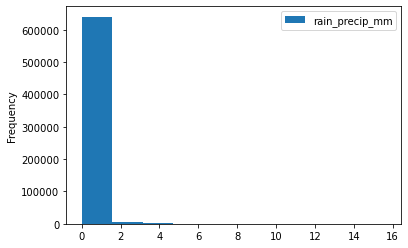

In [25]:
all_data[['rain_precip_mm']].plot.hist()

<AxesSubplot:ylabel='Frequency'>

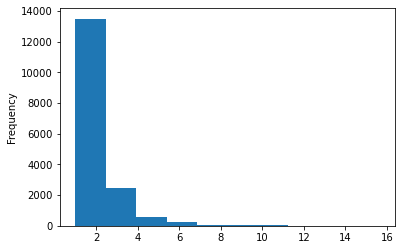

In [28]:
all_data[all_data['rain_precip_mm']>1]['rain_precip_mm'].plot.hist()

In [41]:
print(all_data[all_data['rain_precip_mm']==0].shape[0])
print(all_data[all_data['rain_precip_mm']>0].shape[0]) 
print(all_data.shape[0])

413467
235365
648832


<AxesSubplot:ylabel='Density'>

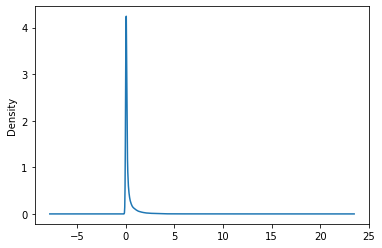

In [42]:
all_data[all_data['rain_precip_mm']>0]['rain_precip_mm'].plot.kde()

In [11]:
dataset_csv=[]
missing_csv=[]
for (region,location),fname in station_csv.items():
    csv_reader,short = load_rows(fname,region,short_locations,long_locations)
    rows_picked = get_random_rows(csv_reader,FILE_PER_LOCATION,station_years[(region,location)])

    pd_rows = parse_rows(rows_picked,location,region,short,short_input_csv_headers,long_input_csv_headers)




    selected_data=pd.DataFrame.from_dict(pd_rows)
    new_dataset_csv, not_found_rows = teacher.generate_new_dataset(
        selected_data,
        config['versiontag'],
        config['split_out_path'],
        file_properties_df,
        config['upper_taxo_links'],
        config['dataset_version'],
        buffer=3600,
        excell_label_headers= {},#config['excell_label_headers'],
        labels_thresholds= {},#config['labels_thresholds'],
        outputSuffix='.wav',
        dry_run=False,
        excell_labels_2_names= {}, #config['excell_labels_2_names'],
        stereo2mono=True,
        overwrite=False,
        sampling_rate=48000,
        label_row_by_threshold=False,
    )
    dataset_csv.extend(new_dataset_csv)
    missing_csv.extend(not_found_rows)


# from copy import deepcopy
# new_dataset_csv_backup = deepcopy(new_dataset_csv)
# not_found_rows_backup = deepcopy(not_found_rows)

# del not_found_rows_backup,new_dataset_csv_backup


# write_csv(config['new_dataset_path'],
#           new_dataset_csv,
#           fieldnames=config['excell_all_headers'])

NameError: name 'station_years' is not defined

In [24]:
len(dataset_csv)

3811

In [29]:
from copy import deepcopy
dataset_csv_backup = deepcopy(dataset_csv)
missing_csv_backup = deepcopy(missing_csv)

excell_all_headers = [
    'data_version', 'Annotator', 'Site ID', 'File Name', 'Date', 'Start Time',
    'End Time', 'Length', 'Clip Path', 'Comments', 'weather_timestamp',
    'region', 'day_length', 'air_temp', 'snow_depth', 'cloud_fraction',
    'relative_humidity', 'runoff', 'rain_precip', 'snow_precip',
    'wind_direction', 'wind_speed'
]

for row in dataset_csv_backup:
    for k,v in row['weather_data'].items():
        if k not in ['location','TIMESTAMP']:
            row[k]=v
        row['weather_timestamp'] = row['weather_data']['TIMESTAMP']
    del row['weather_data']


for row in dataset_csv_backup:
    for k in list(row.keys()):
        if k not in excell_all_headers:
            del row[k]

dataset_csv_unique = {}
for row in dataset_csv_backup:
    dataset_csv_unique[row['Clip Path']] = row
dataset_csv_backup=list(dataset_csv_unique.values())

print(len(dataset_csv_backup))
teacher.write_csv(config['new_dataset_path'],
          dataset_csv_backup,
          fieldnames=excell_all_headers)

3700


In [30]:
dataset_csv_backup[0]

{'data_version': 'W1',
 'Annotator': 'weather_V1',
 'Site ID': 'SINP03',
 'File Name': '/tank/data/nna/real/ivvavik/SINP03/2019/SINP-03_20190513_231602.flac',
 'Start Time': '00:29:50.000000',
 'End Time': '00:30:00.000000',
 'Date': '05/14/2019',
 'Length': '00:00:10.000000',
 'Clip Path': PosixPath('/scratch/enis/data/nna/labeling/samples/weather_V1/audio_weather_V1/ivvavik/SINP03/SINP-03_20190513_231602_73m_48s__73m_58s.wav'),
 'Comments': '',
 'weather_timestamp': '2019-05-14_01:30:00',
 'region': 'ivvavik',
 'day_length': 20.2996368,
 'air_temp': 0.922241211,
 'snow_depth': 0.450530827,
 'cloud_fraction': 0.831612885,
 'relative_humidity': 84.5013275,
 'runoff': 0.0,
 'rain_precip': 3.24604343e-06,
 'snow_precip': 4.02112619e-06,
 'wind_direction': 291.185028,
 'wind_speed': 1.36716318}

In [68]:
len(dataset_csv)

3935

In [12]:
a=[row['Clip Path'] for row in dataset_csv]

In [13]:
len((a)),len(set(a))

(3811, 3700)

In [83]:
for row in dataset_csv:
    m = row['Clip Path']
    if m.exists():
        continue
    else:
        print(row)
        break

{'data_version': 'W2', 'Annotator': 'weather_V2', 'Site ID': '03', 'File Name': '/tank/data/nna/real/dalton/03/2019/S4A10437_20191009_172000.aac', 'Start Time': '17:20:00.000000', 'End Time': '17:20:10.000000', 'Date': '10/09/2019', 'Length': '00:00:10.000000', 'Clip Path': PosixPath('/scratch/enis/data/nna/labeling/samples/weather_V2/audio_weather_V2/dalton/03/S4A10437_20191009_172000_0m_0s__0m_10s.wav'), 'Comments': '', 'weather_timestamp': '2019-10-09_16:30:00', 'region': 'dalton', 'day_length': 9.85344791, 'air_temp': -0.127105713, 'snow_depth': 0.0195905175, 'cloud_fraction': 0.831612885, 'relative_humidity': 95.3483429, 'runoff': 0.0, 'rain_precip': 1.14912109e-05, 'snow_precip': 7.56504087e-05, 'total_precip': 8.71416196e-05, 'wind_direction': 192.373138, 'wind_speed': 1.04121852, 'snow_blowing_ground': 0.0, 'snow_blowing_air': 0.0787686035}
